In [114]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt



In [126]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, t_train), (x_test, t_test) = fashion_mnist.load_data()

In [127]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [128]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

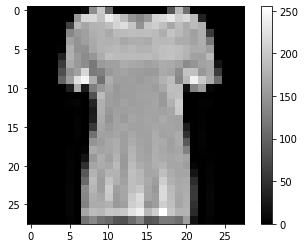

In [129]:
plt.figure()
plt.imshow(x_train[10], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [130]:
x_train = x_train / 255.0
x_test = x_test / 255.0

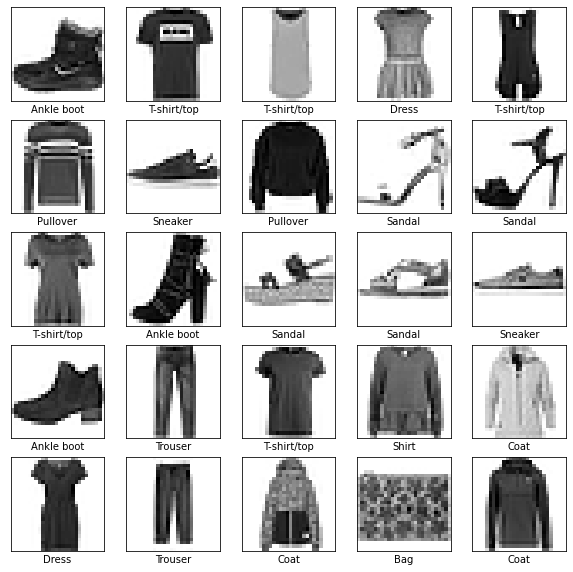

In [131]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[t_train[i]])
plt.show()

In [132]:
xtl = x_train.shape[0]
xsl = x_test.shape[0]
print(xtl, xsl)
x_train = x_train.reshape(xtl, -1)
x_test  = x_test.reshape(xsl, -1)
x_train.shape, x_test.shape

60000 10000


((60000, 784), (10000, 784))

In [133]:
x_train.shape

(60000, 784)

In [134]:
def convertToOneHot(vector, num_classes=None):

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

t_train_hot = convertToOneHot(t_train)
t_test_hot = convertToOneHot(t_test)
t_train_hot.shape

(60000, 10)

# Build the Network

In [154]:
# Activation Functions 
def sigmoid(inputs):
    return 1 / (1 + np.exp(-inputs))
def softmax(inputs):
    val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    return val/ np.sum(val, axis=1, keepdims=True)
def relu(inputs):
  return np.maximum(0, inputs)
# Calculate output values from inputs self.output = np.maximum(0, inputs)
# Loss function 
def log_loss(y_hat, y_target):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    val = np.sum(y_hat * y_target,axis=1)
    return np.mean(-np.log(val))
# Gradient funcrtions for loss and activation 
def gradient_loss(y_hat, y_target):
    return y_hat - y_target
def gradient_sigmoid(layer, grads_in):
    return grads_in * layer.activation_output * (1 - layer.activation_output)
def gradient_relu(layer, grads_in):
    grads_in[layer.inputs <= 0] = 0
    return grads_in 
# Optimizer 
def optimizer(layer, lr):
    layer.weights = layer.weights -lr * layer.dw
    layer.biases = layer.biases -lr * layer.db
def mini_batch(X, y, batchSize):
	for i in np.arange(0, X.shape[0], batchSize):
		yield (X[i:i + batchSize], y[i:i + batchSize])

In [158]:
class layer():
    def __init__ (self, input_size, neuron_no):
        self.neuron_no = neuron_no
        self.weights = 0.1 * np.random.randn(input_size, neuron_no)
        self.biases = np.zeros((1, neuron_no))
    def forward_pass(self, inputs, activation = 'sigmoid'):
        self.inputs = inputs 
        self.outputs = np.dot(inputs, self.weights) + self.biases
        if activation == 'sigmoid': self.activation_output = sigmoid(self.outputs)
        elif activation == 'relu': self.activation_output = relu(self.outputs) 
        elif activation == 'softmax': self.activation_output = softmax(self.outputs)
    def backward_pass(self, grads_in):
        self.dw = np.dot(self.inputs.T, grads_in)
        self.db = np.sum(grads_in, axis=0, keepdims=True)
        self.grads = np.dot(grads_in, self.weights.T)

In [156]:
# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
output_layer = layer(neuron_no=10, input_size=300)

In [140]:
lr = 0.01 
epochs = 5
batch_size = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
output_layer = layer(neuron_no=10, input_size=300)

for epoch in np.arange(0, epochs):
  trainLoss = []
  trainAcc = []
  valLoss = []
  valAcc = []
  for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    trainLoss.append(loss)
    
    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    trainAcc.append(accuracy)

    # Backward pass 
    dL = gradient_loss(output_layer.activation_output, miniY)
    output_layer.backward_pass(dL)
    d_sig = gradient_sigmoid(input_layer, output_layer.grads)
    # print(d_sig)
    input_layer.backward_pass(d_sig)

    # update weights and biases 
    optimizer(input_layer, lr)
    optimizer(output_layer, lr)
  for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss
    loss = log_loss(output_layer.activation_output, miniY)
    # print(output_layer.activation_output.shape, miniY.shape)
    valLoss.append(loss)

    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    valAcc.append(accuracy)

  # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
  print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
  training_loss.append(np.average(trainLoss))
  validation_loss.append(np.average(valLoss))
  training_accuracy.append(np.average(trainAcc))
  validation_accuracy.append(np.average(valAcc))



epoch 0, train loss: 0.569, val loss:0.470, train acc:0.795, val acc:0.829
epoch 1, train loss: 0.416, val loss:0.425, train acc:0.849, val acc:0.846
epoch 2, train loss: 0.376, val loss:0.403, train acc:0.863, val acc:0.855
epoch 3, train loss: 0.351, val loss:0.387, train acc:0.872, val acc:0.861
epoch 4, train loss: 0.332, val loss:0.375, train acc:0.878, val acc:0.865


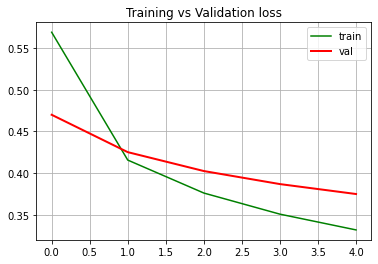

In [141]:
plt.title('Training vs Validation loss')
plt.plot(training_loss, color='g', label='train' )
plt.plot(validation_loss, linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

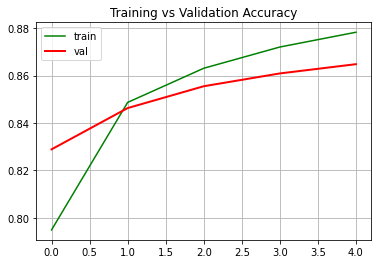

In [143]:
plt.title('Training vs Validation Accuracy')
plt.plot(training_accuracy,color='g', label='train')
plt.plot(validation_accuracy,linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

In [148]:
lr = 0.01 
epochs = 15
batch_size = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
hidden_layer = layer(neuron_no=300, input_size=300)
output_layer = layer(neuron_no=10, input_size=300)

for epoch in np.arange(0, epochs):
  trainLoss = []
  trainAcc = []
  valLoss = []
  valAcc = []
  for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, 
                             activation='sigmoid')
    hidden_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='sigmoid')
    output_layer.forward_pass(inputs=hidden_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    trainLoss.append(loss)
    
    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    trainAcc.append(accuracy)

    # Backward pass 
    dL = gradient_loss(output_layer.activation_output, miniY)
    output_layer.backward_pass(dL)
    d_sig1 = gradient_sigmoid(hidden_layer, output_layer.grads)
    hidden_layer.backward_pass(d_sig1)
    d_sig2 = gradient_sigmoid(input_layer, hidden_layer.grads)
    input_layer.backward_pass(d_sig2)

    # update weights and biases 
    optimizer(input_layer, lr)
    optimizer(output_layer, lr)
  for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, 
                             activation='sigmoid')
    hidden_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='sigmoid')
    output_layer.forward_pass(inputs=hidden_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss
    loss = log_loss(output_layer.activation_output, miniY)
    # print(output_layer.activation_output.shape, miniY.shape)
    valLoss.append(loss)

    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    valAcc.append(accuracy)

  # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
  print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
  training_loss.append(np.average(trainLoss))
  validation_loss.append(np.average(valLoss))
  training_accuracy.append(np.average(trainAcc))
  validation_accuracy.append(np.average(valAcc))



epoch 0, train loss: 1.167, val loss:0.645, train acc:0.684, val acc:0.750
epoch 1, train loss: 0.606, val loss:0.519, train acc:0.798, val acc:0.805
epoch 2, train loss: 0.525, val loss:0.474, train acc:0.822, val acc:0.827
epoch 3, train loss: 0.481, val loss:0.448, train acc:0.836, val acc:0.836
epoch 4, train loss: 0.450, val loss:0.431, train acc:0.845, val acc:0.845
epoch 5, train loss: 0.425, val loss:0.418, train acc:0.852, val acc:0.851
epoch 6, train loss: 0.405, val loss:0.407, train acc:0.858, val acc:0.854
epoch 7, train loss: 0.388, val loss:0.398, train acc:0.863, val acc:0.858
epoch 8, train loss: 0.373, val loss:0.392, train acc:0.867, val acc:0.860
epoch 9, train loss: 0.360, val loss:0.386, train acc:0.872, val acc:0.863
epoch 10, train loss: 0.349, val loss:0.382, train acc:0.876, val acc:0.864
epoch 11, train loss: 0.338, val loss:0.379, train acc:0.880, val acc:0.867
epoch 12, train loss: 0.328, val loss:0.376, train acc:0.883, val acc:0.867
epoch 13, train loss: 

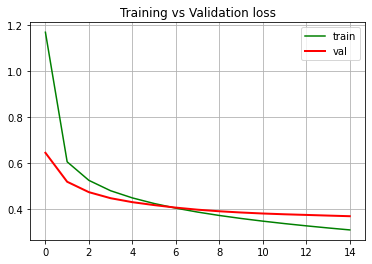

In [149]:
plt.title('Training vs Validation loss')
plt.plot(training_loss, color='g', label='train' )
plt.plot(validation_loss, linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

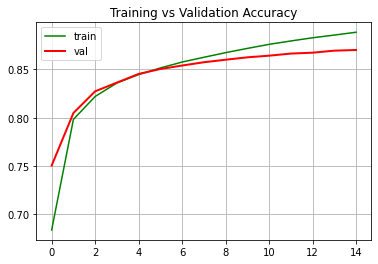

In [150]:
plt.title('Training vs Validation Accuracy')
plt.plot(training_accuracy,color='g', label='train')
plt.plot(validation_accuracy,linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

In [164]:
lr = 0.01 
epochs = 15
batch_size = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
hidden_layer = layer(neuron_no=300, input_size=300)
output_layer = layer(neuron_no=10, input_size=300)

for epoch in np.arange(0, epochs):
  trainLoss = []
  trainAcc = []
  valLoss = []
  valAcc = []
  for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, 
                             activation='sigmoid')
    hidden_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='relu')
    output_layer.forward_pass(inputs=hidden_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    trainLoss.append(loss)
    
    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    trainAcc.append(accuracy)

    # Backward pass 
    dL = gradient_loss(output_layer.activation_output, miniY)
    output_layer.backward_pass(dL)
    d_sig1 = gradient_relu(hidden_layer, output_layer.grads)
    hidden_layer.backward_pass(d_sig1)
    d_sig2 = gradient_sigmoid(input_layer, hidden_layer.grads)
    input_layer.backward_pass(d_sig2)

    # update weights and biases 
    optimizer(input_layer, lr)
    optimizer(output_layer, lr)
  for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, 
                             activation='sigmoid')
    hidden_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='relu')
    output_layer.forward_pass(inputs=hidden_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss
    loss = log_loss(output_layer.activation_output, miniY)
    # print(output_layer.activation_output.shape, miniY.shape)
    valLoss.append(loss)

    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    valAcc.append(accuracy)

  # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
  print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
  training_loss.append(np.average(trainLoss))
  validation_loss.append(np.average(valLoss))
  training_accuracy.append(np.average(trainAcc))
  validation_accuracy.append(np.average(valAcc))



epoch 0, train loss: 0.569, val loss:0.449, train acc:0.792, val acc:0.836
epoch 1, train loss: 0.410, val loss:0.407, train acc:0.850, val acc:0.854
epoch 2, train loss: 0.370, val loss:0.385, train acc:0.863, val acc:0.861
epoch 3, train loss: 0.345, val loss:0.372, train acc:0.872, val acc:0.865
epoch 4, train loss: 0.325, val loss:0.363, train acc:0.878, val acc:0.868
epoch 5, train loss: 0.310, val loss:0.356, train acc:0.884, val acc:0.870
epoch 6, train loss: 0.296, val loss:0.352, train acc:0.889, val acc:0.875
epoch 7, train loss: 0.286, val loss:0.349, train acc:0.893, val acc:0.876
epoch 8, train loss: 0.276, val loss:0.348, train acc:0.897, val acc:0.875
epoch 9, train loss: 0.266, val loss:0.348, train acc:0.900, val acc:0.876
epoch 10, train loss: 0.257, val loss:0.348, train acc:0.904, val acc:0.876
epoch 11, train loss: 0.249, val loss:0.348, train acc:0.907, val acc:0.877
epoch 12, train loss: 0.242, val loss:0.348, train acc:0.910, val acc:0.877
epoch 13, train loss: 

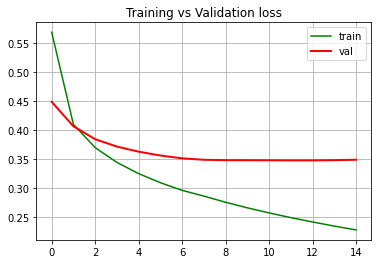

In [165]:
plt.title('Training vs Validation loss')
plt.plot(training_loss, color='g', label='train' )
plt.plot(validation_loss, linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

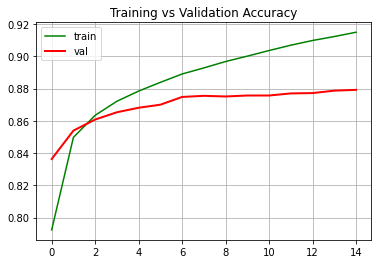

In [166]:
plt.title('Training vs Validation Accuracy')
plt.plot(training_accuracy,color='g', label='train')
plt.plot(validation_accuracy,linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()